# [AB] AI Writing Supporter 프로젝트 - 데이터셋 생성 코드

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import json

In [ ]:
drive.mount('/content/drive')
# data를 저장할 폴더 입니다. 환경에 맞게 수정 하세요.
data_dir = "/content/drive/My Drive/2022 AI SW 온라인 실무 교육 사례 대회/data/train/TL_"
test_dir = "/content/drive/My Drive/2022 AI SW 온라인 실무 교육 사례 대회/data/test/VL_"

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec  4 04:36:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    53W / 350W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
def file_extract(data_dir, essay_type):
    dir = data_dir + essay_type + '/' + essay_type + '/'
    file_list = os.listdir(dir)
    
    df = pd.DataFrame(columns=['essay_main_subject', 'essay_prompt', 'paragraph', 'essay_scoreT_org', 'essay_scoreT_cont', 'essay_scoreT_exp'])
    
    for file in tqdm(file_list):
        with open(dir + file) as f:
            js = json.loads(f.read())
            df.loc[len(df)] = [js['info']['essay_main_subject'], 
                               js['info']['essay_prompt'], js['paragraph'][0]['paragraph_txt'], 
                               js['score']['essay_scoreT_detail']['essay_scoreT_org'],
                               js['score']['essay_scoreT_detail']['essay_scoreT_cont'],
                               js['score']['essay_scoreT_detail']['essay_scoreT_exp']] 
    return df

In [ ]:
essay_types = os.listdir("/content/drive/My Drive/2022 AI SW 온라인 실무 교육 사례 대회/data/train/")
essay_types = list(map(lambda x: x[3:], essay_types))[:5]
essay_types

['주장', '설명글', '찬성반대', '대안제시', '글짓기']

In [ ]:
def score_avg(x, len_x):
    avg = []
    for i in range(len_x):
        avg.append(round(sum(np.array(x).T[i])/3))
    return avg

In [ ]:
for e_type in tqdm(essay_types):
    train_essay = file_extract(data_dir, e_type)
    test_essay = file_extract(test_dir, e_type)

    train_essay['essay_prompt'] = train_essay['essay_prompt'].str.replace('\n\n','')
    test_essay['essay_prompt'] = test_essay['essay_prompt'].str.replace('\n\n','')
    train_essay['paragraph'] = train_essay['paragraph'].str.replace('#@문장구분#','')
    test_essay['paragraph'] = test_essay['paragraph'].str.replace('#@문장구분#','')

    y_col = ['essay_scoreT_org', 'essay_scoreT_cont', 'essay_scoreT_exp']
    y_col_fin = []

    for yc in y_col:
        len_x = len(train_essay[yc][0][0])
        train_essay[yc] = train_essay[yc].apply(lambda x: score_avg(x, len_x))
        test_essay[yc] = test_essay[yc].apply(lambda x: score_avg(x, len_x))

        for i in range(len_x):
            col_name = yc+'_'+str(i)
            y_col_fin.append(col_name)
            train_essay[col_name] = train_essay[yc].apply(lambda x: x[i])
            test_essay[col_name] = test_essay[yc].apply(lambda x: x[i])

    train_essay.to_csv(data_dir[:51]+"data/train/train_"+e_type+".csv", index=False)
    test_essay.to_csv(data_dir[:51]+"data/test/test_"+e_type+".csv", index=False)

100%|██████████| 8596/8596 [04:24<00:00, 32.47it/s] 

100%|██████████| 14575/14575 [08:09<00:00, 29.80it/s]

100%|██████████| 6687/6687 [04:08<00:00, 26.86it/s] 

100%|██████████| 5159/5159 [03:18<00:00, 26.01it/s] 

 47%|████▋     | 2161/4574 [02:29<00:19, 125.32it/s]

In [ ]:
def score_avg_reg(x, len_x):
    avg = []
    for i in range(len_x):
        avg.append(sum(np.array(x).T[i])/3)
    return avg

In [ ]:
for e_type in tqdm(essay_types):
    train_essay = file_extract(data_dir, e_type)
    test_essay = file_extract(test_dir, e_type)

    train_essay['essay_prompt'] = train_essay['essay_prompt'].str.replace('\n\n','')
    test_essay['essay_prompt'] = test_essay['essay_prompt'].str.replace('\n\n','')
    train_essay['paragraph'] = train_essay['paragraph'].str.replace('#@문장구분#','')
    test_essay['paragraph'] = test_essay['paragraph'].str.replace('#@문장구분#','')

    y_col = ['essay_scoreT_org', 'essay_scoreT_cont', 'essay_scoreT_exp']
    y_col_fin = []

    for yc in y_col:
        len_x = len(train_essay[yc][0][0])
        train_essay[yc] = train_essay[yc].apply(lambda x: score_avg_reg(x, len_x))
        test_essay[yc] = test_essay[yc].apply(lambda x: score_avg_reg(x, len_x))

        for i in range(len_x):
            col_name = yc+'_'+str(i)
            y_col_fin.append(col_name)
            train_essay[col_name] = train_essay[yc].apply(lambda x: x[i])
            test_essay[col_name] = test_essay[yc].apply(lambda x: x[i])

    train_essay.to_csv(data_dir[:51]+"data_reg/train/train_"+e_type+".csv", index=False)
    test_essay.to_csv(data_dir[:51]+"data_reg/test/test_"+e_type+".csv", index=False)

100%|██████████| 8596/8596 [03:00<00:00, 47.55it/s] 

100%|██████████| 14575/14575 [05:08<00:00, 47.18it/s] 

100%|██████████| 6687/6687 [02:30<00:00, 44.40it/s] 

100%|██████████| 5159/5159 [01:48<00:00, 47.42it/s] 

100%|██████████| 4574/4574 [01:31<00:00, 50.18it/s] 

100%|██████████| 5/5 [19:25<00:00, 233.15s/it]




---



---




# [AB] AI Writing Supporter 프로젝트 - 작문 데이터 시각화 코드

## 1. 환경설정

### 1-1. 라이브러리 설치 및 폰트 설정

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

### 1-2. 라이브러리 설정

In [ ]:
# Google Colab 라이브러리
from google.colab import drive
from psutil import virtual_memory

# 데이터 처리 및 시각화 라이브러리
import os
import math
from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

from nltk import Text
from konlpy.tag import Okt
from gensim.models.word2vec import Word2Vec
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
import pickle
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

rc('font', family='NanumBarunGothic')

### 1-3. GPU 및 Memory 설정

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec  4 08:17:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    49W / 400W |    632MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## 2. 데이터 처리

### 2-1. 데이터 로드

In [ ]:
drive.mount('/content/drive') # 구글 드라이브 접속

# data를 저장할 폴더 입니다. 환경에 맞게 수정 하세요.
data_dir = '/content/drive/My Drive/2022 AI SW 온라인 실무 교육 사례 대회/data/train/' # train 데이터셋 경로
test_dir = '/content/drive/My Drive/2022 AI SW 온라인 실무 교육 사례 대회/data/test/' # test 데이터셋 경로

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2-2. 전체 데이터셋 생성

In [ ]:
essay_types = ['주장', '설명글', '찬성반대', '대안제시', '글짓기'] # 작문 종류

In [ ]:
cols = ['essay_main_subject', # 작문 주제
        'essay_prompt', # 작문 프롬프트
        'paragraph', # 작문 텍스트
        'essay_scoreT_org_0', 'essay_scoreT_org_1', 'essay_scoreT_org_2', # 에세이 11가지 평가 정보
        'essay_scoreT_org_3', 'essay_scoreT_cont_0', 'essay_scoreT_cont_1',
        'essay_scoreT_cont_2', 'essay_scoreT_cont_3', 'essay_scoreT_exp_0',
        'essay_scoreT_exp_1', 'essay_scoreT_exp_2'] 

In [ ]:
all_essay = pd.DataFrame(columns=cols) # 전체 에세이 데이터를 저장할 데이터프레임

# 전체 데이터셋을 불러와서 하나의 데이터프레임에 저장
for e_type in essay_types:
    df = pd.read_csv(data_dir+'train_'+e_type+'.csv')[cols]
    all_essay = pd.concat([all_essay, df], axis=0)
    df = pd.read_csv(test_dir+'test_'+e_type+'.csv')[cols]
    all_essay = pd.concat([all_essay, df], axis=0)

all_essay.shape # 전체 데이터셋 크기

(45497, 14)

## 3. 데이터 시각화

### 3-1. 평가지표 값 분포

Text(0.5, 0.98, '평가지표값 분포')

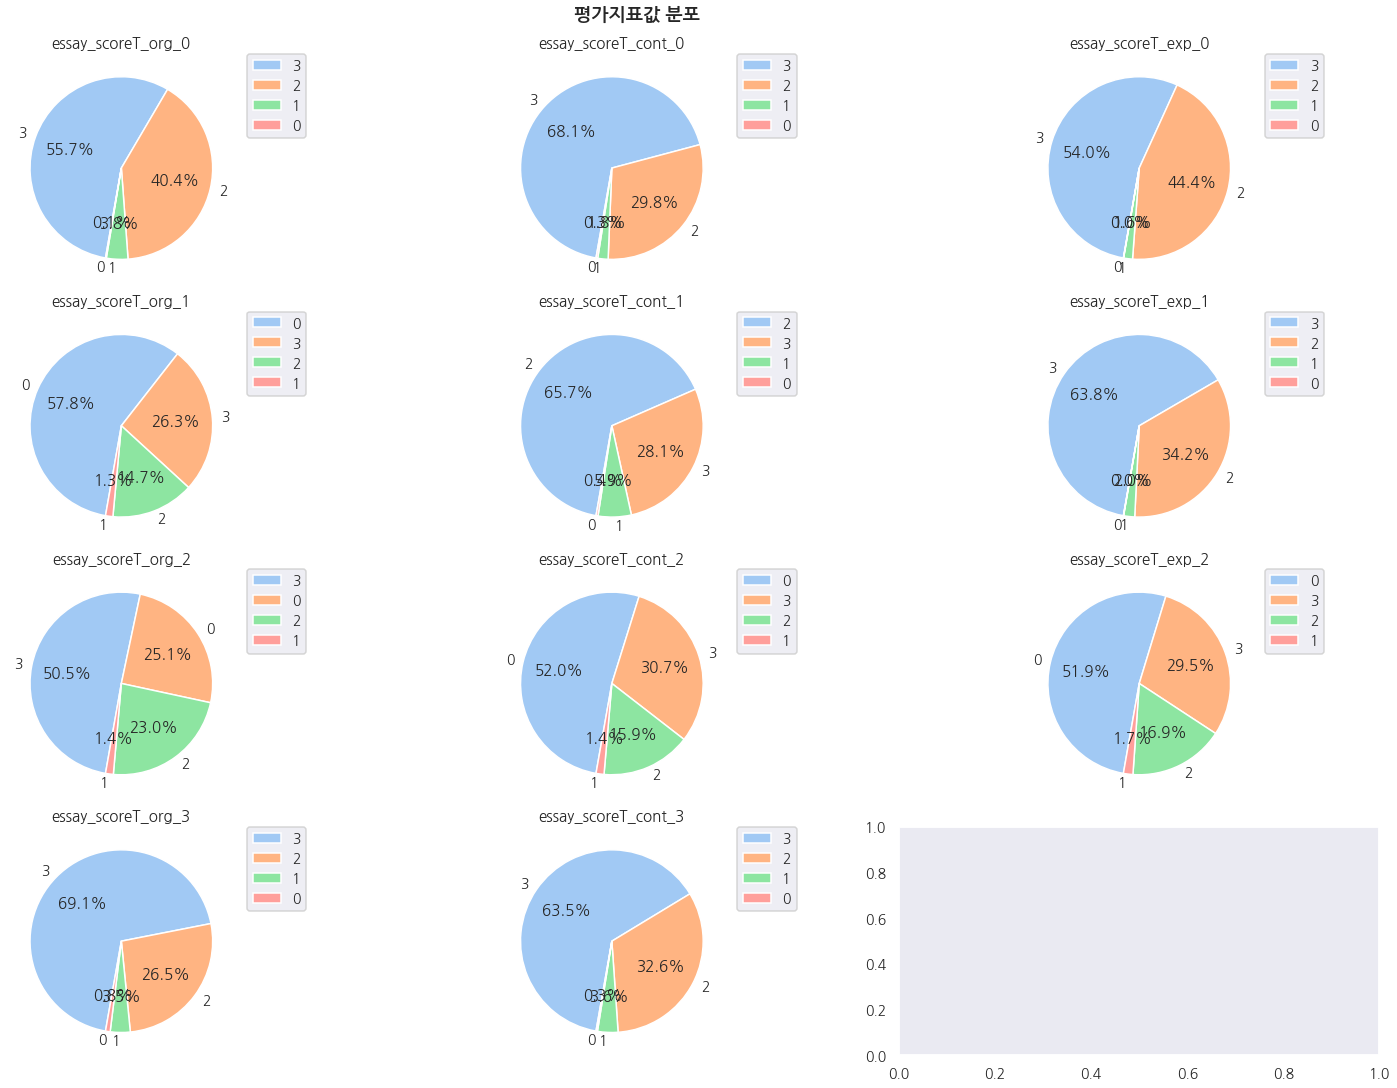

In [ ]:
# 시각화 환경 설정
sns.set(font="NanumGothic", font_scale=0.85, 
        context="talk",
        palette="pastel",
        style="dark")

fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(21,15), 
                        gridspec_kw={'wspace':0.1},
                        constrained_layout=True)

y_cols = ['essay_scoreT_org_0', 'essay_scoreT_org_1', 'essay_scoreT_org_2',
          'essay_scoreT_org_3', 'essay_scoreT_cont_0', 'essay_scoreT_cont_1',
          'essay_scoreT_cont_2', 'essay_scoreT_cont_3', 'essay_scoreT_exp_0',
          'essay_scoreT_exp_1', 'essay_scoreT_exp_2'] # 평가지표 컬럼

col_num = -1
for i in range(3):
    for j in range(4):
        col_num += 1

        if i == 2 and j ==3: # 총 11개 이므로 12번째 그래프는 생략
            continue
        else:
            ratio = all_essay[y_cols[col_num]].value_counts().values
            labels = all_essay[y_cols[col_num]].value_counts().index
            
            axs[j][i].set_title(y_cols[col_num])
            axs[j][i].pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False) # 파이 차트 생성
            axs[j][i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # 범례 설정 

fig.suptitle('평가지표값 분포',fontweight ="bold")  

### 3-2. 텍스트 데이터 단어 분포 

essay_main_subject
텍스트의 최소 단어 개수 : 1
텍스트의 최대 단어 개수 : 8
텍스트의 평균 단어 개수 : 4.095083192298393


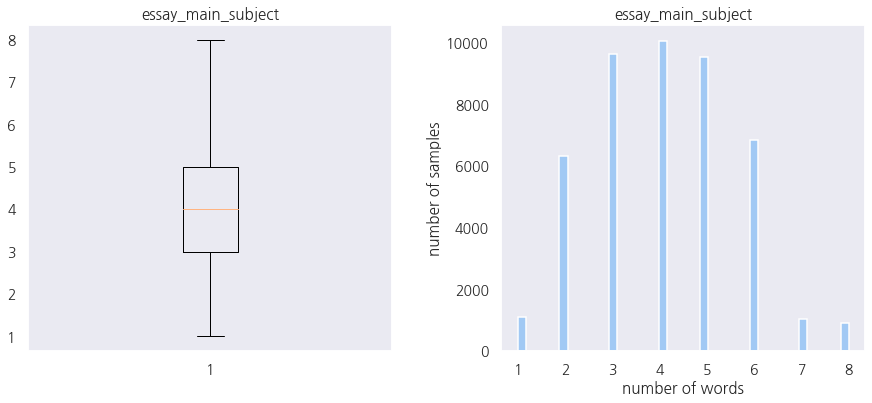

essay_prompt
텍스트의 최소 단어 개수 : 40
텍스트의 최대 단어 개수 : 185
텍스트의 평균 단어 개수 : 102.22891619227642


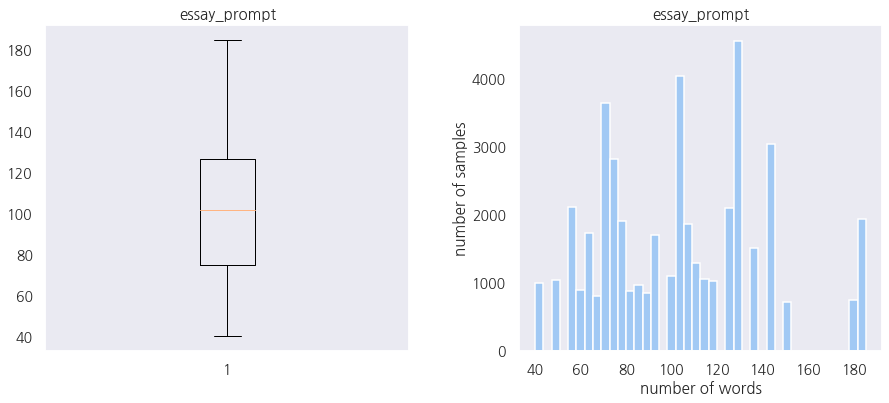

paragraph
텍스트의 최소 단어 개수 : 1
텍스트의 최대 단어 개수 : 1207
텍스트의 평균 단어 개수 : 135.4053454073895


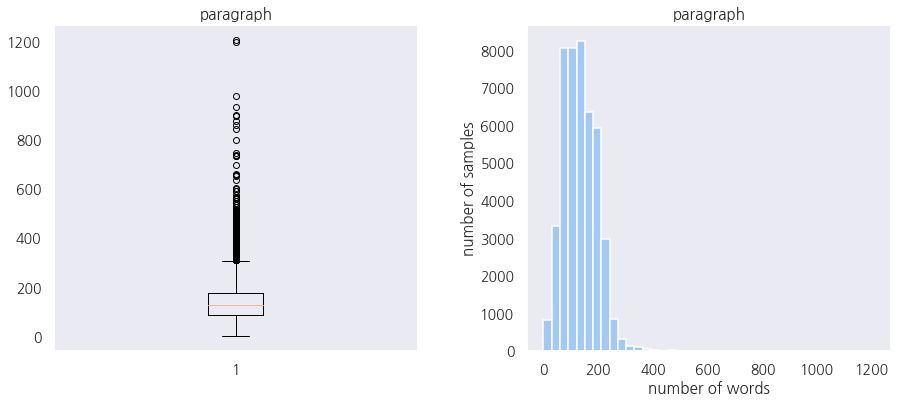

In [ ]:
x_cols = ["essay_main_subject", "essay_prompt", "paragraph"]

# 길이 분포 출력
for col in x_cols:
    print(col)
    text_len = [len(s.split()) for s in all_essay[col]]

    print('텍스트의 최소 단어 개수 : {}'.format(np.min(text_len)))
    print('텍스트의 최대 단어 개수 : {}'.format(np.max(text_len)))
    print('텍스트의 평균 단어 개수 : {}'.format(np.mean(text_len)))

    fig = plt.figure(figsize=(15, 6)) 
    plt.subplot(1,2,1)
    plt.boxplot(text_len)
    plt.title(col)

    plt.subplot(1,2,2)
    plt.title(col)
    plt.hist(text_len, bins=40)
    plt.xlabel('number of words')
    plt.ylabel('number of samples')

    plt.subplots_adjust(wspace=0.3)
    plt.show()

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(all_essay['paragraph'])

threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 521205
등장 빈도가 4번 이하인 희귀 단어의 수: 436481
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 84724
단어 집합에서 희귀 단어의 비율: 83.74459185924924
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 10.110087287954931


### 3-3. Word2Vec

#### 3-4. 단어 빈도

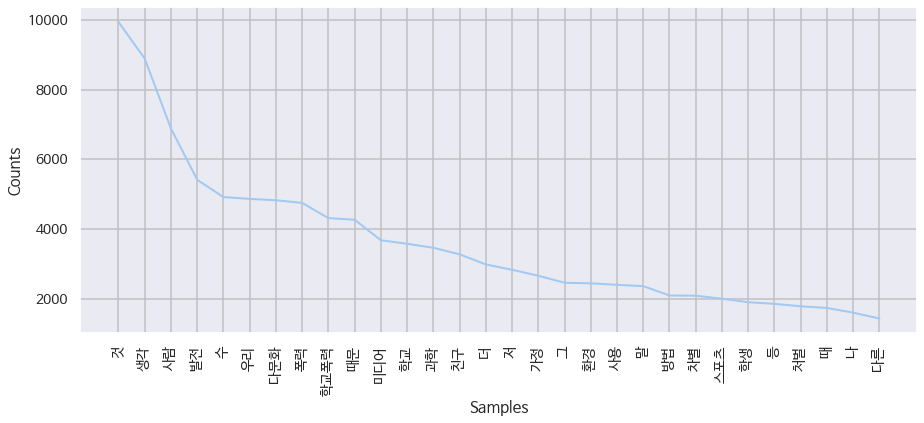

100%|██████████| 4000/4000 [01:33<00:00, 42.70it/s]


(2052, 50)


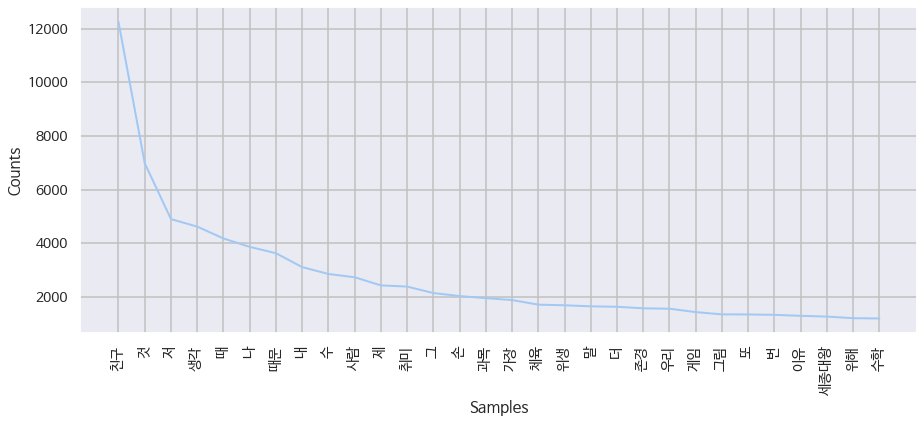

100%|██████████| 4000/4000 [01:14<00:00, 54.00it/s]


(1998, 50)


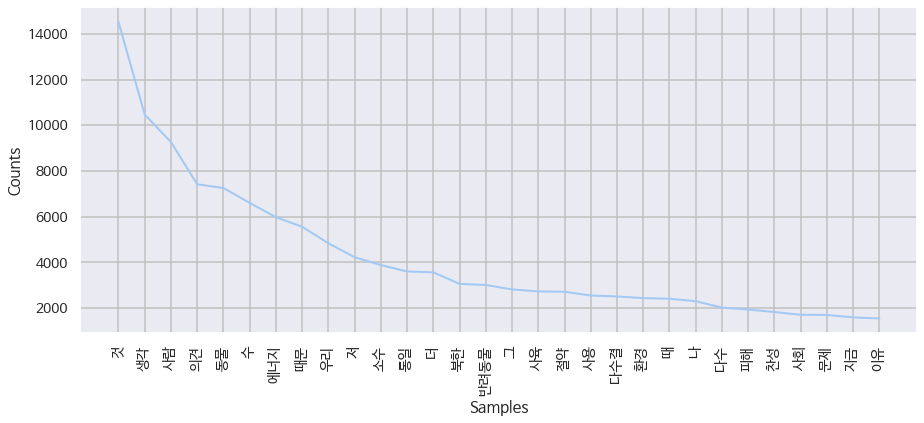

100%|██████████| 4000/4000 [01:28<00:00, 45.27it/s]


(2180, 50)


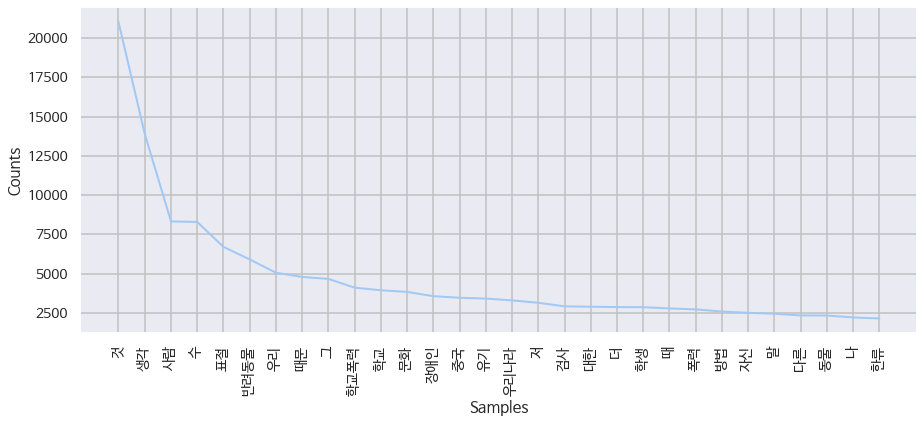

100%|██████████| 4000/4000 [01:48<00:00, 36.83it/s]


(2705, 50)


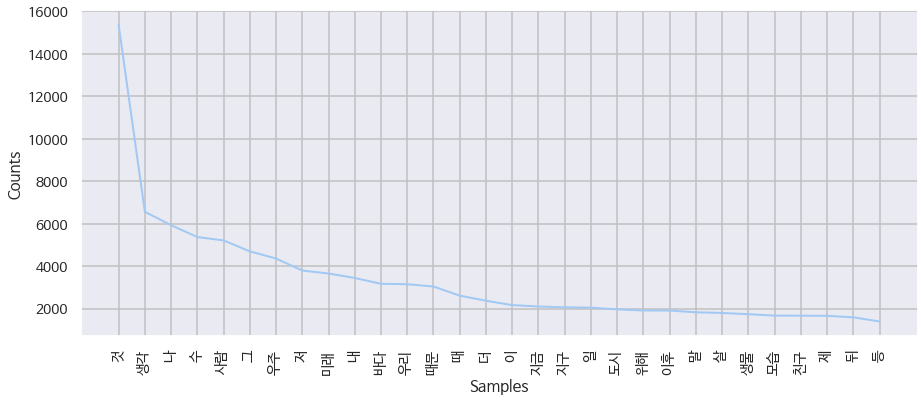

100%|██████████| 4000/4000 [01:42<00:00, 38.84it/s]


(3639, 50)


In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어 정의

for e_type in essay_types:
    df = pd.read_csv(data_dir+'train_'+e_type+'.csv')[cols][:4000]
    all_document = ' '.join(list(df['paragraph']))
    okt = Okt()

    fig = plt.figure(figsize=(15, 6)) 
    kolaw = Text(okt.nouns(all_document), name="kolaw")
    kolaw.plot(30)
    plt.show()

    tokenized_data = []
    for sentence in tqdm(df['paragraph']):
        tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
        tokenized_data.append(stopwords_removed_sentence)

    w2v_model = Word2Vec(sentences = tokenized_data, size = 50, window = 5, min_count = 20, workers = 4, sg = 0)
    print(w2v_model.wv.vectors.shape)
    w2v_model.save('/content/drive/My Drive/2022 AI SW 온라인 실무 교육 사례 대회/w2v_model/w2v'+e_type+'.model') 

#### 3-5. 단어 간 유사도

100%|██████████| 5/5 [00:01<00:00,  3.19it/s]
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


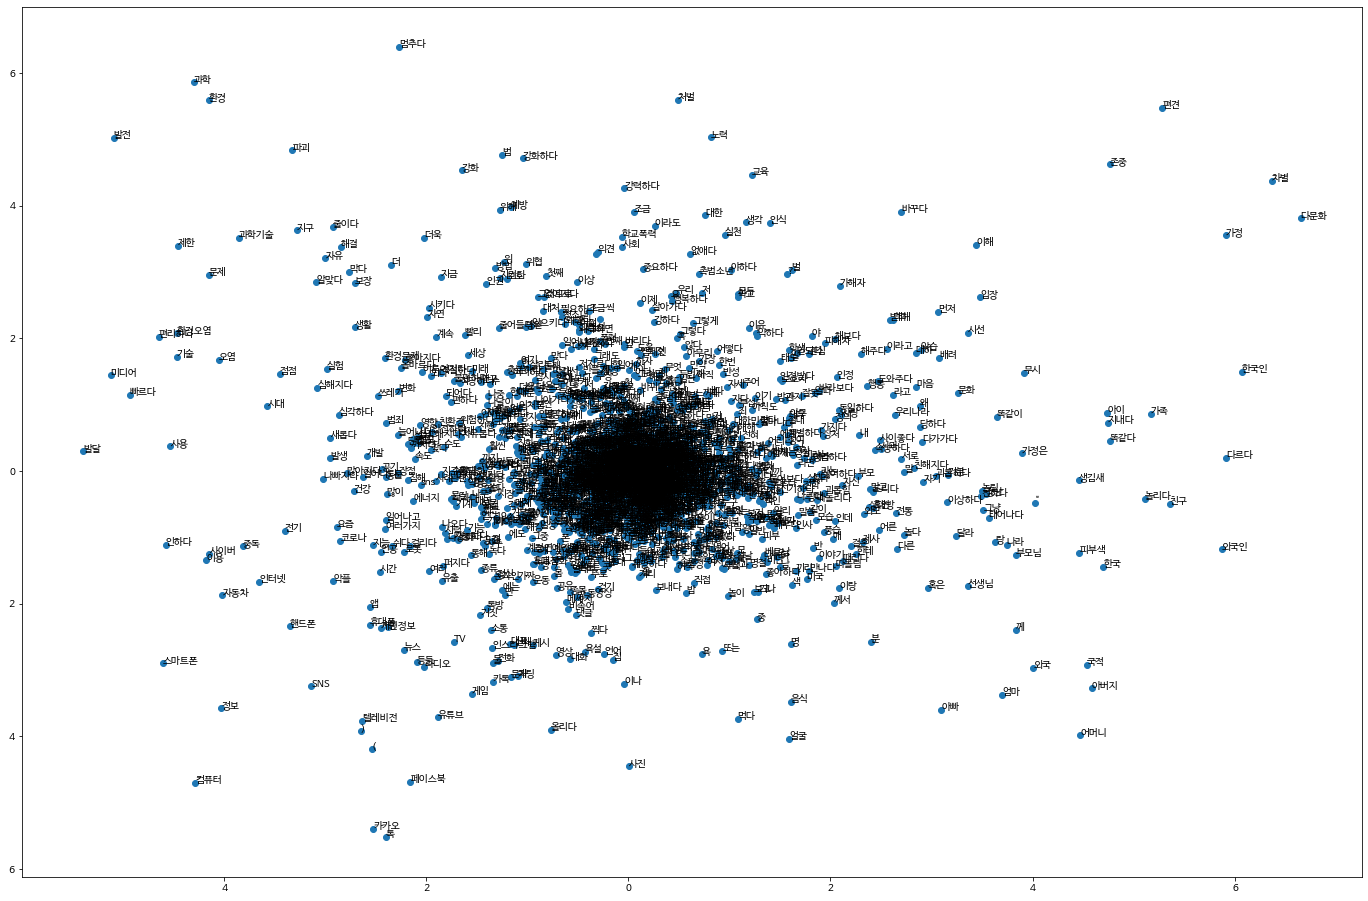

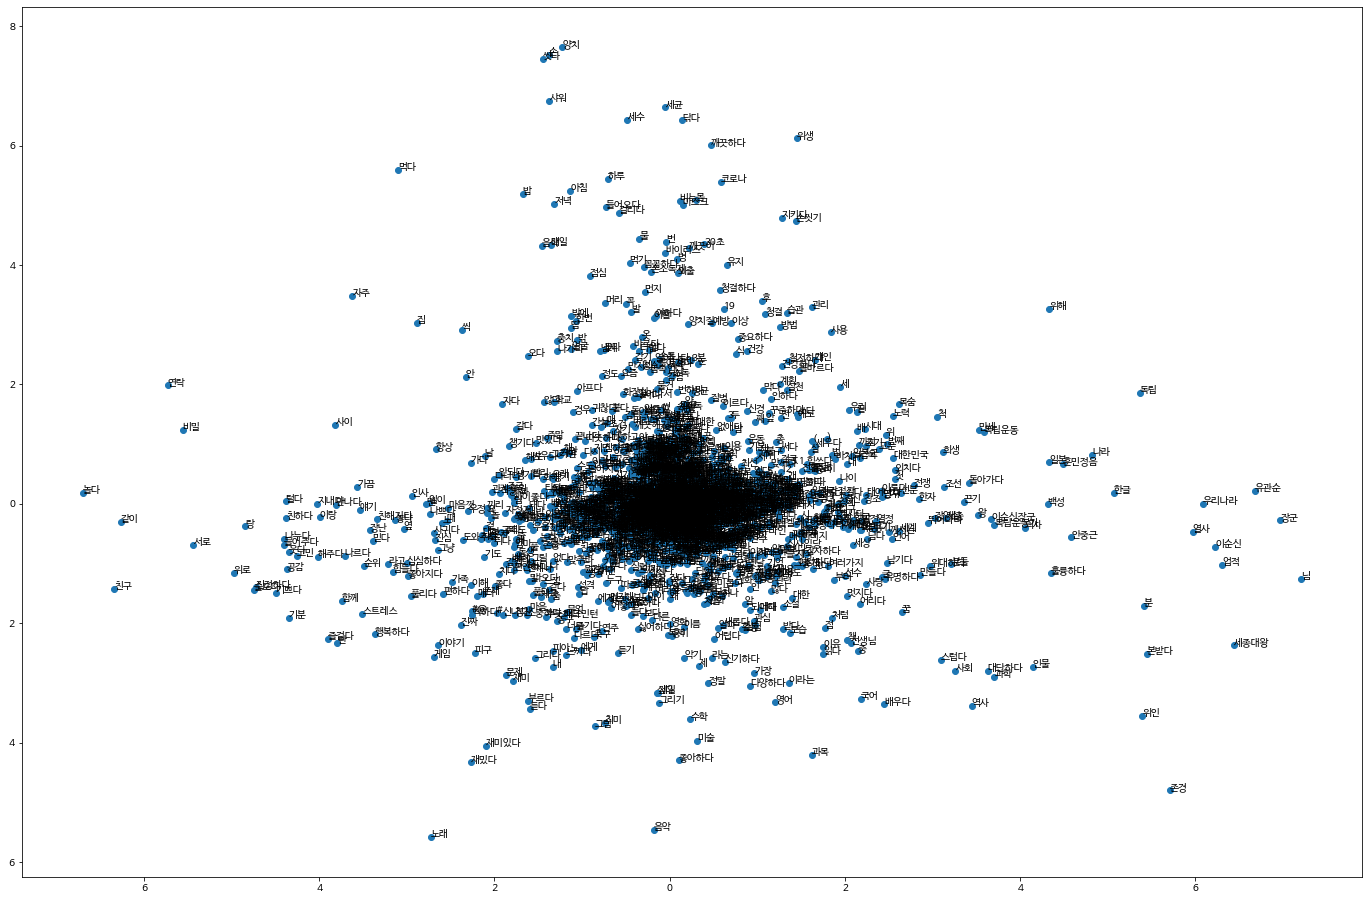

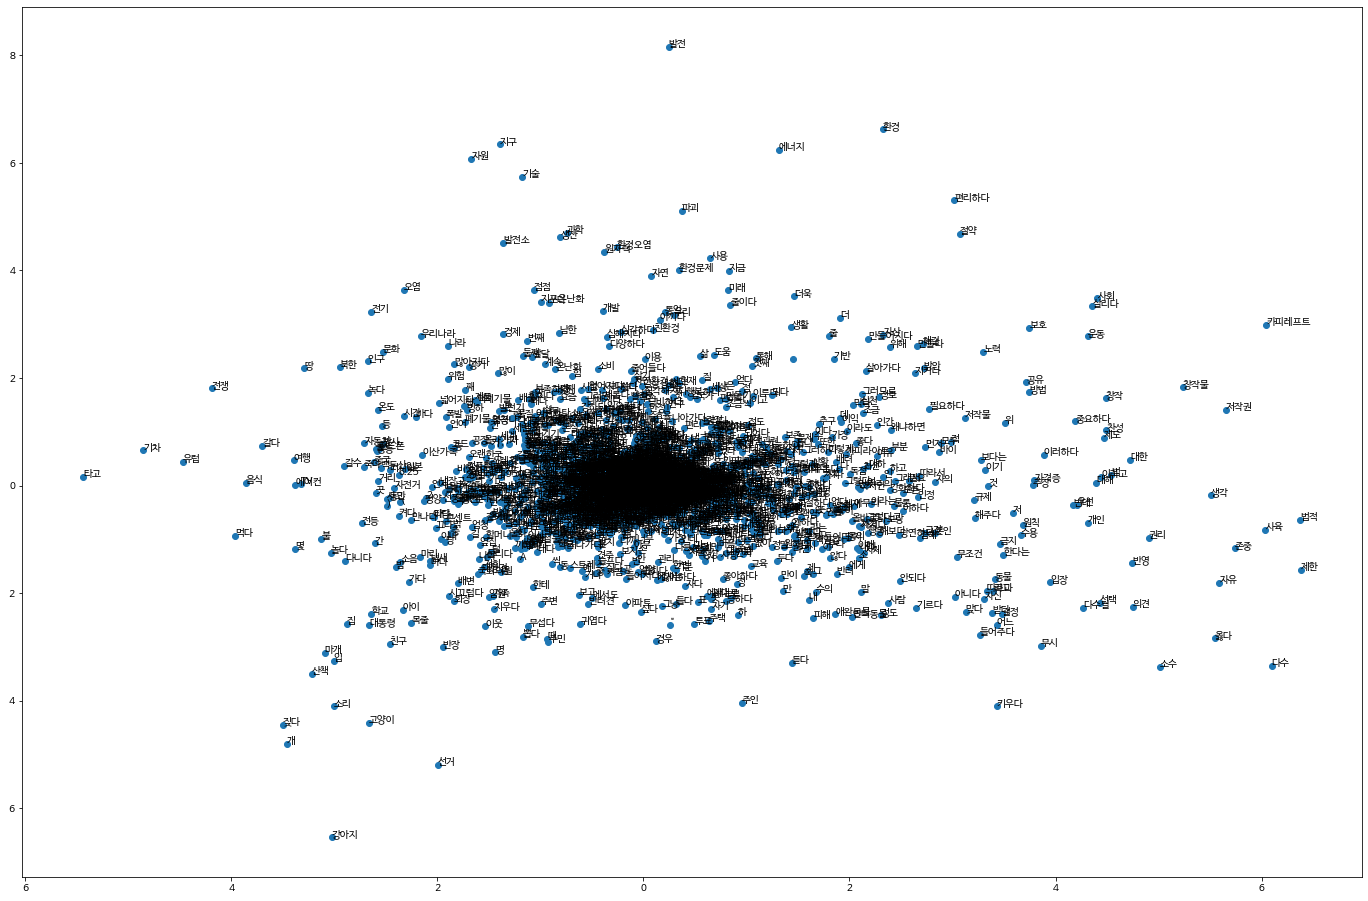

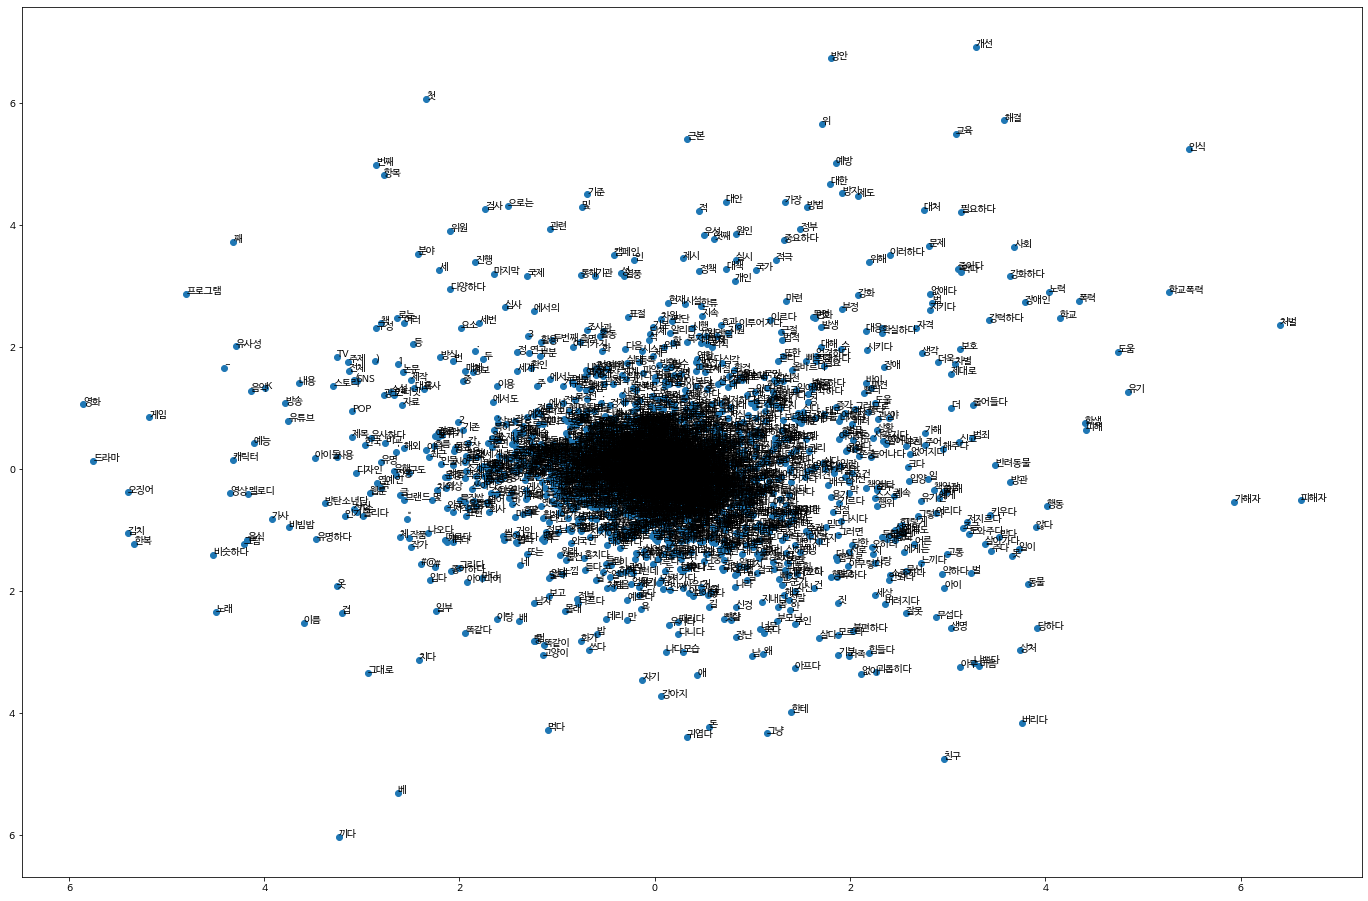

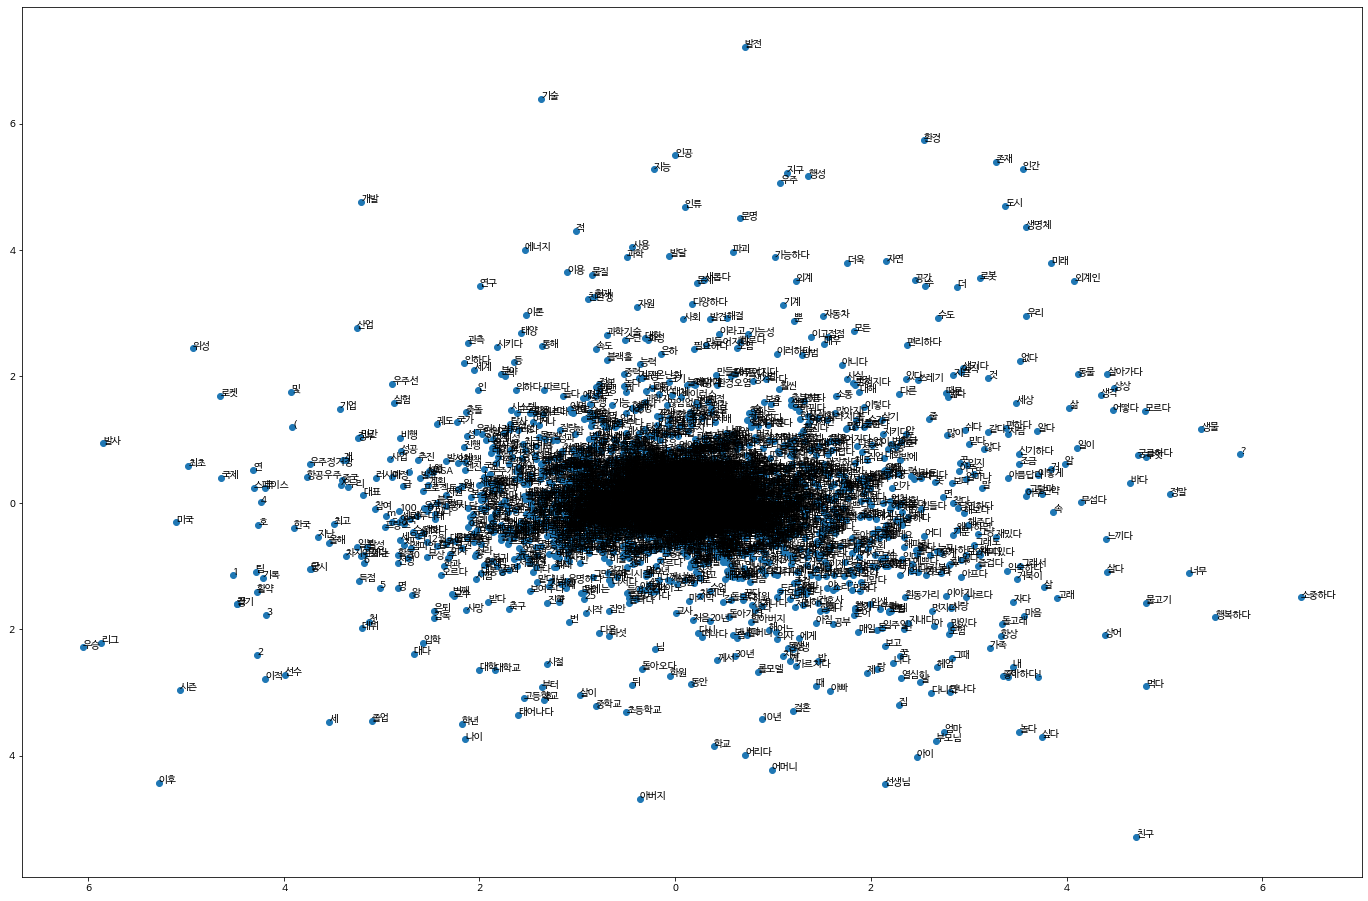

In [ ]:
for e_type in tqdm(essay_types):
    # 단어 벡터를 구한다.
    word_vectors = Word2Vec.load('/content/drive/My Drive/2022 AI SW 온라인 실무 교육 사례 대회/w2v_model/w2v'+e_type+'.model').wv

    vocabs = word_vectors.vocab.keys()
    word_vectors_list = [word_vectors[v] for v in vocabs]

    pca = PCA(n_components=2)   # 2개의 차원으로 축소
    xys = pca.fit_transform(word_vectors_list)
    xs = xys[:,0]
    ys = xys[:,1]

    # 단어와 2차원 X축의 값, Y축으로 2차원 그래프를 그린다.
    # matplotlib.rc('font', family='NanumBarunGothic')

    plt.figure(figsize=(24, 16))
    plt.scatter(xs, ys, marker = 'o')
    for i,v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

- t-SNE를 활용한 시각화    
[참고자료](https://nbviewer.org/github/dreamgonfly/phone-review-nlp/blob/master/phone_reviews_nlp.ipynb#topic=0&lambda=1&term=)

In [ ]:
for e_type in tqdm(essay_types):
    essay2vec = Word2Vec.load('/content/drive/My Drive/2022 AI SW 온라인 실무 교육 사례 대회/w2v_model/w2v'+e_type+'.model')
    essay2vec.init_sims()

    # take word vectors of most frequent words.
    num_words = 2000
    word_embeddings = pd.DataFrame(essay2vec.wv.syn0norm[:num_words, :], index=essay2vec.wv.index2word[:num_words])
    
    USE_PREMADE_TSNE = False

    tsne_filepath = 'tsne.pkl'

    if not USE_PREMADE_TSNE:
        
        tsne = TSNE(random_state=0)
        tsne_points = tsne.fit_transform(word_embeddings.values)
        with open(tsne_filepath, 'wb') as f:
            pickle.dump(tsne_points, f)
    else:
        with open(tsne_filepath, 'rb') as f:
            tsne_points = pickle.load(f)

    tsne_df = pd.DataFrame(tsne_points, index=word_embeddings.index, columns=['x_coord', 'y_coord'])
    tsne_df['word'] = tsne_df.index

    # prepare the data in a form suitable for bokeh.
    plot_data = ColumnDataSource(tsne_df)

    # create the plot and configure it
    tsne_plot = figure(title='t-SNE Word Embeddings',
                    plot_width = 800,
                    plot_height = 800,
                    active_scroll='wheel_zoom'
                    )

    # add a hover tool to display words on roll-over
    tsne_plot.add_tools( HoverTool(tooltips = '@word') )

    tsne_plot.circle('x_coord', 'y_coord', source=plot_data,
                    color='red', line_alpha=0.2, fill_alpha=0.1,
                    size=10, hover_line_color='orange')

    # adjust visual elements of the plot
    # tsne_plot.title.text_font_size = value('16pt')
    tsne_plot.xaxis.visible = False
    tsne_plot.yaxis.visible = False
    tsne_plot.grid.grid_line_color = None
    tsne_plot.outline_line_color = None

    # show time!
    show(tsne_plot);

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-29-a5509457de4a>:7: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  word_embeddings = pd.DataFrame(essay2vec.wv.syn0norm[:num_words, :], index=essay2vec.wv.index2word[:num_words])
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


 20%|██        | 1/5 [00:07<00:31,  7.93s/it]<ipython-input-29-a5509457de4a>:7: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  word_embeddings = pd.DataFrame(essay2vec.wv.syn0norm[:num_words, :], index=essay2vec.wv.index2word[:num_words])
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


 40%|████      | 2/5 [00:14<00:21,  7.33s/it]<ipython-input-29-a5509457de4a>:7: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  word_embeddings = pd.DataFrame(essay2vec.wv.syn0norm[:num_words, :], index=essay2vec.wv.index2word[:num_words])
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


 60%|██████    | 3/5 [00:22<00:14,  7.32s/it]<ipython-input-29-a5509457de4a>:7: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  word_embeddings = pd.DataFrame(essay2vec.wv.syn0norm[:num_words, :], index=essay2vec.wv.index2word[:num_words])
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


 80%|████████  | 4/5 [00:29<00:07,  7.28s/it]<ipython-input-29-a5509457de4a>:7: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  word_embeddings = pd.DataFrame(essay2vec.wv.syn0norm[:num_words, :], index=essay2vec.wv.index2word[:num_words])
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


100%|██████████| 5/5 [00:36<00:00,  7.30s/it]




---



---




# [AB] AI Writing Supporter 프로젝트 - AI 모델링 코드

## 1. 환경설정

### 1-1. 라이브러리 및 폰트

In [ ]:
!pip install sentencepiece
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 12.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 414 kB/s 
     |████████████████████████████████| 465 kB 50.6 MB/s 


In [ ]:
# Google Colab 및 데이터처리 라이브러리
from google.colab import drive
import pandas as pd
import numpy as np
import os
import gzip
import shutil
from tqdm import tqdm

# 자연어처리 라이브러리
import sentencepiece as spm
from konlpy.tag import Okt

# 모델링 라이브러리
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Layer

# 성능평가 라이브러리
from sklearn.metrics import mean_squared_error, mean_absolute_error

### 1-2. 버전 확인

In [ ]:
print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2.9.2
1.3.5
1.21.6


### 1-3. GPU & Memory 확인

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec  4 12:32:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |    312MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## 2. 데이터 전처리

### 2-1. 데이터 로드

In [ ]:
drive.mount('/content/drive') # 구글 드라이브 접속

# data를 저장할 폴더 입니다. 환경에 맞게 수정 하세요.
data_dir = "/content/drive/My Drive/2022 AI SW 온라인 실무 교육 사례 대회/data_reg/train/"
test_dir = "/content/drive/My Drive/2022 AI SW 온라인 실무 교육 사례 대회/data_reg/test/"

Mounted at /content/drive


### 2-2. 데이터 EDA
- `data_visualization.ipynb`

### 2-3. 데이터 전처리
- 불용어 제거 및 문장 인코딩

#### 2-2-1. SentencePiece

In [ ]:
def sentencepiece_preprocessing(train, test, vocab_size, maxlen_subject, maxlen_prompt, maxlen_paragraph):

    vocab_file = f"{data_dir[:51]}vocab/kowiki.model"
    vocab = spm.SentencePieceProcessor()
    vocab.load(vocab_file)

    y_col = train.columns.drop(["essay_main_subject", "essay_prompt", "paragraph", 'essay_scoreT_org', 'essay_scoreT_cont', 'essay_scoreT_exp'])
    
    x_train = train[["essay_main_subject", "essay_prompt", "paragraph"]]
    y_train = train[y_col]
    x_test = test[["essay_main_subject", "essay_prompt", "paragraph"]]
    y_test = test[y_col]
    
    for l in tqdm(range(len(x_train))):
        x_train['essay_main_subject'][l] = vocab.encode_as_ids(x_train['essay_main_subject'][l])
        x_train['essay_prompt'][l] = vocab.encode_as_ids(x_train['essay_prompt'][l])
        x_train['paragraph'][l] = vocab.encode_as_ids(x_train['paragraph'][l])

    for l in tqdm(range(len(x_test))):
        x_test['essay_main_subject'][l] = vocab.encode_as_ids(x_test['essay_main_subject'][l])
        x_test['essay_prompt'][l] = vocab.encode_as_ids(x_test['essay_prompt'][l])
        x_test['paragraph'][l] = vocab.encode_as_ids(x_test['paragraph'][l])

    # 패딩
    x_train1 = keras.preprocessing.sequence.pad_sequences(x_train['essay_main_subject'], maxlen=maxlen_subject)
    x_train2 = keras.preprocessing.sequence.pad_sequences(x_train['essay_prompt'], maxlen=maxlen_prompt)
    x_train3 = keras.preprocessing.sequence.pad_sequences(x_train['paragraph'], maxlen=maxlen_paragraph)
    x_test1 = keras.preprocessing.sequence.pad_sequences(x_test['essay_main_subject'], maxlen=maxlen_subject)
    x_test2 = keras.preprocessing.sequence.pad_sequences(x_test['essay_prompt'], maxlen=maxlen_prompt)
    x_test3 = keras.preprocessing.sequence.pad_sequences(x_test['paragraph'], maxlen=maxlen_paragraph)

    return [x_train1, x_train2, x_train3], y_train, [x_test1, x_test2, x_test3], y_test, 0


#### 2-2-2. KoNLPy
- Okt, Hannanum, Kkma, Komoran 사용 가능

In [ ]:
def konlpy_preprocessing(train, test, vocab_size, maxlen_subject, maxlen_prompt, maxlen_paragraph):

    okt = Okt()
    # stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    y_col = train.columns.drop(["essay_main_subject", "essay_prompt", "paragraph", 'essay_scoreT_org', 'essay_scoreT_cont', 'essay_scoreT_exp'])
    
    x_train = train[["essay_main_subject", "essay_prompt", "paragraph"]]
    y_train = train[y_col]
    x_test = test[["essay_main_subject", "essay_prompt", "paragraph"]]
    y_test = test[y_col]
    
    for l in tqdm(range(len(x_train))):
        x_train['essay_main_subject'][l] = okt.morphs(x_train['essay_main_subject'][l], stem=True)
        x_train['essay_prompt'][l] = okt.morphs(x_train['essay_prompt'][l], stem=True)
        x_train['paragraph'][l] = okt.morphs(x_train['paragraph'][l], stem=True)

    for l in tqdm(range(len(x_test))):
        x_test['essay_main_subject'][l] = okt.morphs(x_test['essay_main_subject'][l], stem=True)
        x_test['essay_prompt'][l] = okt.morphs(x_test['essay_prompt'][l], stem=True)
        x_test['paragraph'][l] = okt.morphs(x_test['paragraph'][l], stem=True)

    tokenizer1 = Tokenizer() # 정수 인코딩
    tokenizer1.fit_on_texts(x_train['essay_main_subject']) # tokenizer.word_index로 확인 가능
    tokenizer2 = Tokenizer() # 정수 인코딩
    tokenizer2.fit_on_texts(x_train['essay_prompt']) # tokenizer.word_index로 확인 가능
    tokenizer3 = Tokenizer() # 정수 인코딩
    tokenizer3.fit_on_texts(x_train['paragraph']) # tokenizer.word_index로 확인 가능

    x_train['essay_main_subject'] = tokenizer1.texts_to_sequences(x_train['essay_main_subject'])
    x_train['essay_prompt'] = tokenizer2.texts_to_sequences(x_train['essay_prompt'])
    x_train['paragraph'] = tokenizer3.texts_to_sequences(x_train['paragraph'])
    x_test['essay_main_subject'] = tokenizer1.texts_to_sequences(x_test['essay_main_subject'])
    x_test['essay_prompt'] = tokenizer2.texts_to_sequences(x_test['essay_prompt'])
    x_test['paragraph'] = tokenizer3.texts_to_sequences(x_test['paragraph'])

    # 패딩
    x_train1 = keras.preprocessing.sequence.pad_sequences(x_train['essay_main_subject'], maxlen=maxlen_subject)
    x_train2 = keras.preprocessing.sequence.pad_sequences(x_train['essay_prompt'], maxlen=maxlen_prompt)
    x_train3 = keras.preprocessing.sequence.pad_sequences(x_train['paragraph'], maxlen=maxlen_paragraph)
    x_test1 = keras.preprocessing.sequence.pad_sequences(x_test['essay_main_subject'], maxlen=maxlen_subject)
    x_test2 = keras.preprocessing.sequence.pad_sequences(x_test['essay_prompt'], maxlen=maxlen_prompt)
    x_test3 = keras.preprocessing.sequence.pad_sequences(x_test['paragraph'], maxlen=maxlen_paragraph)

    return [x_train1, x_train2, x_train3], y_train, [x_test1, x_test2, x_test3], y_test, [tokenizer1, tokenizer2, tokenizer3]

In [ ]:
def data_preprocessing(method, train, test, maxlen):
    
    vocab_size = 20000 

    if method == 'SentencePiece':
        return sentencepiece_preprocessing(train, test, vocab_size, maxlen[0], maxlen[1], maxlen[2])
    
    elif method == 'konlpy':
        return konlpy_preprocessing(train, test, vocab_size, maxlen[0], maxlen[1], maxlen[2])
    
    else:
        print('None')

## 3. 모델

### 3-1. 모델

#### 3-1-1. LSTM

#### 3-1-2. Attention

In [ ]:
class Attention(keras.layers.Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
          'W_regularizer': self.W_regularizer,
          'b_regularizer': self.b_regularizer,
          'W_constraint': self.W_constraint,
          'b_constraint': self.b_constraint,
          'bias': self.bias
        })
        return config

      
    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

#### 3-1-3. Transformer
- Transformer 블록을 레이어로 사용

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

- 임베딩 레이어

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### 3-2. 모델 구현 함수

In [ ]:
def make_model(model_name, maxlen, vocab_size):
    embed_dim = 32  # Embedding size for each token

    y_cols = ['essay_scoreT_org_0', 'essay_scoreT_org_1', 'essay_scoreT_org_2',
                'essay_scoreT_org_3', 'essay_scoreT_cont_0', 'essay_scoreT_cont_1',
                'essay_scoreT_cont_2', 'essay_scoreT_cont_3', 'essay_scoreT_exp_0',
                'essay_scoreT_exp_1', 'essay_scoreT_exp_2']

    outputs = []

    if model_name == 'LSTM': 
        # 입력 레이어
        inputs_subject = layers.Input(shape=(maxlen[0],))
        inputs_prompt = layers.Input(shape=(maxlen[1],))
        inputs_paragraph = layers.Input(shape=(maxlen[2],))

        # 임베딩 및 LSTM 레이어 설정
        x1 = layers.Embedding(vocab_size, embed_dim)(inputs_subject)
        x1 = tf.keras.layers.LSTM(64, return_sequences=True)(x1)
        x1 = layers.GlobalAveragePooling1D()(x1)

        x2 = layers.Embedding(vocab_size, embed_dim)(inputs_prompt)
        x2 = tf.keras.layers.LSTM(64, return_sequences=True)(x2)
        x2 = layers.GlobalAveragePooling1D()(x2)

        x3 = layers.Embedding(vocab_size, embed_dim)(inputs_paragraph)
        x3 = tf.keras.layers.LSTM(64, return_sequences=True)(x3)
        x1 = layers.GlobalAveragePooling1D()(x3)

        # 레이어 결합
        c = layers.concatenate([x1, x2, x3])
        c = layers.Dropout(0.1)(c)
        c = layers.Dense(32, activation="relu")(c)
        c = layers.Dropout(0.1)(c)

        # 출력 레이어
        for y_col in y_cols:
            outputs.append(layers.Dense(1, name=y_col)(c))
    
    elif model_name == 'Attention':
        # 입력 레이어
        inputs_subject = layers.Input(shape=(maxlen[0],))
        inputs_prompt = layers.Input(shape=(maxlen[1],))
        inputs_paragraph = layers.Input(shape=(maxlen[2],))

        # 임베딩 및 Attention 레이어 설정
        x1 = layers.Embedding(vocab_size, embed_dim)(inputs_subject)
        x1 = Attention(maxlen[0])(x1)
        
        x2 = layers.Embedding(vocab_size, embed_dim)(inputs_prompt)
        x2 = Attention(maxlen[1])(x2)

        x3 = layers.Embedding(vocab_size, embed_dim)(inputs_paragraph)
        x3 = Attention(maxlen[2])(x3)

        # 레이어 결합
        c = layers.concatenate([x1, x2, x3])
        c = layers.Dense(64, activation="relu")(c)
        c = layers.Dropout(0.1)(c)

        # 출력 레이어
        for y_col in y_cols:
            outputs.append(layers.Dense(1, name=y_col)(c))

    elif model_name == 'Transformer':
        num_heads = 4  # Number of attention heads
        ff_dim = 32  # Hidden layer size in feed forward network inside transformer

        # 입력 레이어
        inputs_subject = layers.Input(shape=(maxlen[0],))
        inputs_prompt = layers.Input(shape=(maxlen[1],))
        inputs_paragraph = layers.Input(shape=(maxlen[2],))

        # 임베딩 및 Transformer block 레이어 설정
        embedding_layer1 = TokenAndPositionEmbedding(maxlen[0], vocab_size, embed_dim)
        x1 = embedding_layer1(inputs_subject)
        transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)

        x1 = transformer_block1(x1)
        x1 = layers.GlobalAveragePooling1D()(x1)
        x1 = layers.Dropout(0.1)(x1)

        embedding_layer2 = TokenAndPositionEmbedding(maxlen[1], vocab_size, embed_dim)
        x2 = embedding_layer2(inputs_prompt)
        transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim)

        x2 = transformer_block2(x2)
        x2 = layers.GlobalAveragePooling1D()(x2)
        x2 = layers.Dropout(0.1)(x2)

        embedding_layer3 = TokenAndPositionEmbedding(maxlen[2], vocab_size, embed_dim)
        x3 = embedding_layer3(inputs_paragraph)
        transformer_block3 = TransformerBlock(embed_dim, num_heads, ff_dim)

        x3 = transformer_block3(x3)
        x3 = layers.GlobalAveragePooling1D()(x3)
        x3 = layers.Dropout(0.1)(x3)

        # 레이어 결합
        c = layers.concatenate([x1, x2, x3])
        c = layers.Dense(64, activation="relu")(c)
        c = layers.Dropout(0.1)(c)
        c = layers.Dense(32, activation="relu")(c)
        c = layers.Dropout(0.1)(c)

        # 출력 레이어
        for y_col in y_cols:
            outputs.append(layers.Dense(1, name=y_col)(c))

    else:
        print("모델을 지정해주세요.")

    return keras.Model(inputs=[inputs_subject, inputs_prompt, inputs_paragraph], outputs=outputs)

### 3-3. 모델 실행 함수

In [ ]:
def model_run(model, x_train, y_train, checkpoint_path, optimizer="adam"):
  epochs = 500
  batch_size = 32

  callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, save_weights_only=True, verbose=1, save_best_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=0.0001, mode='min'
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
  ]
  model.compile(
    optimizer=optimizer,
    loss='mse', 
    metrics=['mae']
  )
  history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
  )

### 3-4. 모델 학습

In [ ]:
def preprocessing_and_modeling(essay_type, model_name, preprocessing_method, model_algorithm, maxlen, vocab_size):
    train = pd.read_csv(data_dir+'train_'+essay_type+'.csv')
    test = pd.read_csv(test_dir+'test_'+essay_type+'.csv')
    print(train.shape, test.shape)
    print(train.head())

    train_pp = train.reset_index().drop('index', axis=1)
    test_pp = test.reset_index().drop('index', axis=1)

    x_train, y_train, x_test, y_test, tokenizer_data = data_preprocessing(preprocessing_method, train_pp, test_pp, maxlen)
    # print(x_train[0].shape, x_train[1].shape, x_train[2].shape, y_train[0].shape, y_train[1].shape, y_train[2].shape, x_test.shape, y_test.shape)

    # 모델 저장 경로
    model_dir = data_dir[:51]+model_name +'/'
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)

    # 체크포인트 파일 저장 경로
    checkpoint_path = model_dir+"checkpoints_"+model_name+".ckpt"

    model = make_model(model_algorithm, maxlen, vocab_size)
    print(model.summary())

    plot_model(model, to_file=model_name+'.png')
    plot_model(model, to_file=model_name+'_shapes.png', show_shapes=True)

    y_train_list = [y_train['essay_scoreT_org_0'], y_train['essay_scoreT_org_1'], y_train['essay_scoreT_org_2'],
                y_train['essay_scoreT_org_3'], y_train['essay_scoreT_cont_0'], y_train['essay_scoreT_cont_1'],
                y_train['essay_scoreT_cont_2'], y_train['essay_scoreT_cont_3'], y_train['essay_scoreT_exp_0'],
                y_train['essay_scoreT_exp_1'], y_train['essay_scoreT_exp_2']]

    model_run(  model,
                x_train, 
                y_train_list, 
                checkpoint_path, 
                optimizer="adam")

In [ ]:
essay_types = ['주장', '설명글', '찬성반대', '대안제시', '글짓기']
for e_type in essay_types:
    preprocessing_and_modeling(e_type, 'model_transformer_'+e_type, 'SentencePiece', 'Transformer', [20, 200, 2000], 20000)

(8596, 17) (1488, 17)
  essay_main_subject                                       essay_prompt  \
0           폭력 예방 방법   요즘 학교에서는 신체적인 폭력뿐만 아니라 미디어 발달로 인한 사이버 폭력과 언어폭...   
1           폭력 예방 방법   요즘 학교에서는 신체적인 폭력뿐만 아니라 미디어 발달로 인한 사이버 폭력과 언어폭...   
2           폭력 예방 방법   요즘 학교에서는 신체적인 폭력뿐만 아니라 미디어 발달로 인한 사이버 폭력과 언어폭...   
3           폭력 예방 방법   요즘 학교에서는 신체적인 폭력뿐만 아니라 미디어 발달로 인한 사이버 폭력과 언어폭...   
4           폭력 예방 방법   요즘 학교에서는 신체적인 폭력뿐만 아니라 미디어 발달로 인한 사이버 폭력과 언어폭...   

                                           paragraph  \
0  학교 폭력을 줄일 수 있는 방법은 첫번째. 학교폭력을 당하는 아이가 있다면 보고있지...   
1  요즘 학교폭력이 많이 일어나고 있다. 그리고 언어폭력과 사이버폭력도 많이 일어나고있...   
2  요즘 SNS를 하는 아이들이 많아졌다. 나도 SNS를 한지 얼마 되지 않았을 때 친...   
3  모든 폭력을 포함하여 1가지 라도 초함되는 피해자는 굉장히 괴로울것이다. 또한 가해...   
4  학교 폭력을 줄일 수 있는 방법은 다양하다. 그 폭력이 무엇인지에 따라 대처하는 방...   

                                    essay_scoreT_org  \
0                               [3.0, 0.0, 3.0, 3.0]   
1  [2.3333333333333335, 0.0, 2.6666666666666665, ...   
2  [2.6666666666666665

  0%|          | 0/8596 [00:00<?, ?it/s]<ipython-input-54-baa4758fe681>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_main_subject'][l] = vocab.encode_as_ids(x_train['essay_main_subject'][l])
<ipython-input-54-baa4758fe681>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_prompt'][l] = vocab.encode_as_ids(x_train['essay_prompt'][l])
<ipython-input-54-baa4758fe681>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

Model: "model_51"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_154 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 input_155 (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 input_156 (InputLayer)         [(None, 2000)]       0           []                               
                                                                                                  
 token_and_position_embedding_7  (None, 20, 32)      640640      ['input_154[0][0]']              
 2 (TokenAndPositionEmbedding)                                                             

  0%|          | 0/14575 [00:00<?, ?it/s]<ipython-input-54-baa4758fe681>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_main_subject'][l] = vocab.encode_as_ids(x_train['essay_main_subject'][l])
<ipython-input-54-baa4758fe681>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_prompt'][l] = vocab.encode_as_ids(x_train['essay_prompt'][l])
<ipython-input-54-baa4758fe681>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

Model: "model_52"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_157 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 input_158 (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 input_159 (InputLayer)         [(None, 2000)]       0           []                               
                                                                                                  
 token_and_position_embedding_7  (None, 20, 32)      640640      ['input_157[0][0]']              
 5 (TokenAndPositionEmbedding)                                                             

  0%|          | 0/6687 [00:00<?, ?it/s]<ipython-input-54-baa4758fe681>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_main_subject'][l] = vocab.encode_as_ids(x_train['essay_main_subject'][l])
<ipython-input-54-baa4758fe681>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_prompt'][l] = vocab.encode_as_ids(x_train['essay_prompt'][l])
<ipython-input-54-baa4758fe681>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_160 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 input_161 (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 input_162 (InputLayer)         [(None, 2000)]       0           []                               
                                                                                                  
 token_and_position_embedding_7  (None, 20, 32)      640640      ['input_160[0][0]']              
 8 (TokenAndPositionEmbedding)                                                             

  0%|          | 0/5159 [00:00<?, ?it/s]<ipython-input-54-baa4758fe681>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_main_subject'][l] = vocab.encode_as_ids(x_train['essay_main_subject'][l])
<ipython-input-54-baa4758fe681>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_prompt'][l] = vocab.encode_as_ids(x_train['essay_prompt'][l])
<ipython-input-54-baa4758fe681>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_163 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 input_164 (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 input_165 (InputLayer)         [(None, 2000)]       0           []                               
                                                                                                  
 token_and_position_embedding_8  (None, 20, 32)      640640      ['input_163[0][0]']              
 1 (TokenAndPositionEmbedding)                                                             

  0%|          | 0/4574 [00:00<?, ?it/s]<ipython-input-54-baa4758fe681>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_main_subject'][l] = vocab.encode_as_ids(x_train['essay_main_subject'][l])
<ipython-input-54-baa4758fe681>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_prompt'][l] = vocab.encode_as_ids(x_train['essay_prompt'][l])
<ipython-input-54-baa4758fe681>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

Model: "model_55"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_166 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 input_167 (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 input_168 (InputLayer)         [(None, 2000)]       0           []                               
                                                                                                  
 token_and_position_embedding_8  (None, 20, 32)      640640      ['input_166[0][0]']              
 4 (TokenAndPositionEmbedding)                                                             

## 4. 성능 평가

### 4-1. 성능 평가 함수

In [ ]:
def evalution(e_type, model_name, preprocessing_method, model_algorithm, maxlen, vocab_size):
    train = pd.read_csv(data_dir+'train_'+e_type+'.csv')
    test = pd.read_csv(test_dir+'test_'+e_type+'.csv')
    print(train.shape, test.shape)
    print(train.head())

    train_pp = train.reset_index().drop('index', axis=1)
    test_pp = test.reset_index().drop('index', axis=1)

    x_train, y_train, x_test, y_test, tokenizer_data = data_preprocessing(preprocessing_method, train_pp, test_pp, maxlen)

    # 모델 저장 경로
    model_dir = data_dir[:51]+model_name +'/'
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)

    # 체크포인트 파일 저장 경로
    checkpoint_path = model_dir+"checkpoints_"+model_name+".ckpt"

    model = make_model(model_algorithm, maxlen, vocab_size)
    model.load_weights(checkpoint_path)
    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"],
    )

    # data_pre = model.predict(x_test)
    # print(data_pre)
    pred_z = model.predict(x_test)
    pred_z = np.asarray(pred_z).astype('float32')
    y_col = y_test.columns
    
    eval = []

    print(e_type)
    for i in range(11):
        print(str(i+1)+'번째 평가항목')
        mse = mean_squared_error(y_test[y_col[i]], pred_z[i])
        mae = mean_absolute_error(y_test[y_col[i]], pred_z[i])
        print("MSE: "+str(mse))
        print("MAE: "+str(mae))
        eval.append([mse, mae])
    return eval

### 4-2. 성능평가

In [ ]:
essay_types = ['주장', '설명글', '찬성반대', '대안제시', '글짓기']
eval_list = []

for e_type in essay_types:
    eval_list.append(evalution(e_type,'model_transformer_'+e_type,  'SentencePiece', 'Transformer', [20, 200, 2000], 20000))

(8596, 17) (1488, 17)
  essay_main_subject                                       essay_prompt  \
0           폭력 예방 방법   요즘 학교에서는 신체적인 폭력뿐만 아니라 미디어 발달로 인한 사이버 폭력과 언어폭...   
1           폭력 예방 방법   요즘 학교에서는 신체적인 폭력뿐만 아니라 미디어 발달로 인한 사이버 폭력과 언어폭...   
2           폭력 예방 방법   요즘 학교에서는 신체적인 폭력뿐만 아니라 미디어 발달로 인한 사이버 폭력과 언어폭...   
3           폭력 예방 방법   요즘 학교에서는 신체적인 폭력뿐만 아니라 미디어 발달로 인한 사이버 폭력과 언어폭...   
4           폭력 예방 방법   요즘 학교에서는 신체적인 폭력뿐만 아니라 미디어 발달로 인한 사이버 폭력과 언어폭...   

                                           paragraph  \
0  학교 폭력을 줄일 수 있는 방법은 첫번째. 학교폭력을 당하는 아이가 있다면 보고있지...   
1  요즘 학교폭력이 많이 일어나고 있다. 그리고 언어폭력과 사이버폭력도 많이 일어나고있...   
2  요즘 SNS를 하는 아이들이 많아졌다. 나도 SNS를 한지 얼마 되지 않았을 때 친...   
3  모든 폭력을 포함하여 1가지 라도 초함되는 피해자는 굉장히 괴로울것이다. 또한 가해...   
4  학교 폭력을 줄일 수 있는 방법은 다양하다. 그 폭력이 무엇인지에 따라 대처하는 방...   

                                    essay_scoreT_org  \
0                               [3.0, 0.0, 3.0, 3.0]   
1  [2.3333333333333335, 0.0, 2.6666666666666665, ...   
2  [2.6666666666666665

  0%|          | 0/8596 [00:00<?, ?it/s]<ipython-input-8-04dc57e93c1d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_main_subject'][l] = vocab.encode_as_ids(x_train['essay_main_subject'][l])
<ipython-input-8-04dc57e93c1d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_prompt'][l] = vocab.encode_as_ids(x_train['essay_prompt'][l])
<ipython-input-8-04dc57e93c1d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

47/47 [==============================] - 7s 96ms/step
주장
1번째 평가항목
MSE: 0.5683384473064995
MAE: 0.5652339076055849
2번째 평가항목
MSE: 1.0498375457110884
MAE: 0.6009116749768229
3번째 평가항목
MSE: 0.31405518014809003
MAE: 0.3916005566649433
4번째 평가항목
MSE: 0.9055921175383181
MAE: 0.5811338686387599
5번째 평가항목
MSE: 0.4833950500786931
MAE: 0.4790077566245979
6번째 평가항목
MSE: 0.4961708205917837
MAE: 0.5251221719021011
7번째 평가항목
MSE: 0.41459999359888283
MAE: 0.4618126292809791
8번째 평가항목
MSE: 0.6031135233010615
MAE: 0.5620201650112334
9번째 평가항목
MSE: 0.25112340701772956
MAE: 0.4060162030774633
10번째 평가항목
MSE: 0.2887285458954211
MAE: 0.4120213699169911
11번째 평가항목
MSE: 0.6181014992373527
MAE: 0.5120410789805715
(14575, 17) (1841, 17)
  essay_main_subject                                       essay_prompt  \
0     존경하는 위인에 대한 생각   세상에는 훌륭한 일을 하고 뛰어난 업적을 쌓아 역사에 이름을 남긴 위인들이 많습니...   
1     존경하는 위인에 대한 생각   세상에는 훌륭한 일을 하고 뛰어난 업적을 쌓아 역사에 이름을 남긴 위인들이 많습니...   
2      친구에 대한 본인의 생각   여러분은 진정한 친구에 대해 생각해본 적이 있나요? 집에 항상 같이

  0%|          | 0/14575 [00:00<?, ?it/s]<ipython-input-8-04dc57e93c1d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_main_subject'][l] = vocab.encode_as_ids(x_train['essay_main_subject'][l])
<ipython-input-8-04dc57e93c1d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_prompt'][l] = vocab.encode_as_ids(x_train['essay_prompt'][l])
<ipython-input-8-04dc57e93c1d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

58/58 [==============================] - 6s 97ms/step
설명글
1번째 평가항목
MSE: 0.24526607814739676
MAE: 0.40457041071913025
2번째 평가항목
MSE: 0.1542012890140531
MAE: 0.2631911069516274
3번째 평가항목
MSE: 0.16257006610963431
MAE: 0.26667433190924217
4번째 평가항목
MSE: 0.24833869624515365
MAE: 0.37245917186429706
5번째 평가항목
MSE: 0.20832465160748775
MAE: 0.3601663012489901
6번째 평가항목
MSE: 0.21822358096900277
MAE: 0.3631145572740056
7번째 평가항목
MSE: 7.691951280089434e-06
MAE: 0.001979226382367823
8번째 평가항목
MSE: 0.21974819833687442
MAE: 0.36070469175584285
9번째 평가항목
MSE: 0.19445736119231508
MAE: 0.36387109320469785
10번째 평가항목
MSE: 0.2282610113100063
MAE: 0.39828888620562725
11번째 평가항목
MSE: 0.26823493917611
MAE: 0.2829744868775047
(6687, 17) (988, 17)
  essay_main_subject                                       essay_prompt  \
0  소수의 의견에 대한 본인의 생각   민주주의 사회에서의 의사결정은 다수결의 원칙으로 정합니다. 여기서 다수결이란 더 ...   
1  소수의 의견에 대한 본인의 생각   민주주의 사회에서의 의사결정은 다수결의 원칙으로 정합니다. 여기서 다수결이란 더 ...   
2  소수의 의견에 대한 본인의 생각   민주주의 사회에서의 의사결정은 다수결의 

  0%|          | 0/6687 [00:00<?, ?it/s]<ipython-input-8-04dc57e93c1d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_main_subject'][l] = vocab.encode_as_ids(x_train['essay_main_subject'][l])
<ipython-input-8-04dc57e93c1d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_prompt'][l] = vocab.encode_as_ids(x_train['essay_prompt'][l])
<ipython-input-8-04dc57e93c1d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

31/31 [==============================] - 4s 99ms/step
찬성반대
1번째 평가항목
MSE: 0.3812001493116332
MAE: 0.46583124138565685
2번째 평가항목
MSE: 0.13541271642820382
MAE: 0.17436880714356817
3번째 평가항목
MSE: 0.3965737331946012
MAE: 0.41906807727247036
4번째 평가항목
MSE: 0.6608710472072349
MAE: 0.5307002127090126
5번째 평가항목
MSE: 0.6186128487719228
MAE: 0.4919432508639801
6번째 평가항목
MSE: 0.38040701945753336
MAE: 0.44247208722689857
7번째 평가항목
MSE: 0.6136906166274679
MAE: 0.4992788512204421
8번째 평가항목
MSE: 0.6452083649180229
MAE: 0.5292989913268611
9번째 평가항목
MSE: 0.22040620746408368
MAE: 0.38166961182466885
10번째 평가항목
MSE: 0.23418500174689083
MAE: 0.37552620742002485
11번째 평가항목
MSE: 0.2536338019611832
MAE: 0.3092942297101705
(5159, 17) (923, 17)
           essay_main_subject  \
0  학교 폭력에 대한 본인 생각 및 해결방안을 작성   
1  학교 폭력에 대한 본인 생각 및 해결방안을 작성   
2  학교 폭력에 대한 본인 생각 및 해결방안을 작성   
3        반려동물 증가와 유기에 대한 대안제시   
4        반려동물 증가와 유기에 대한 대안제시   

                                        essay_prompt  \
0   학교 폭력은 학교 내외에서 

  0%|          | 0/5159 [00:00<?, ?it/s]<ipython-input-8-04dc57e93c1d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_main_subject'][l] = vocab.encode_as_ids(x_train['essay_main_subject'][l])
<ipython-input-8-04dc57e93c1d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_prompt'][l] = vocab.encode_as_ids(x_train['essay_prompt'][l])
<ipython-input-8-04dc57e93c1d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

29/29 [==============================] - 3s 99ms/step
대안제시
1번째 평가항목
MSE: 0.49313726583772066
MAE: 0.5276141226958954
2번째 평가항목
MSE: 0.19105427188264007
MAE: 0.22924179955509735
3번째 평가항목
MSE: 0.38110503609030627
MAE: 0.4408387746049765
4번째 평가항목
MSE: 0.5660697634120402
MAE: 0.4428462842691243
5번째 평가항목
MSE: 0.4488910693605955
MAE: 0.45467444075794167
6번째 평가항목
MSE: 0.4188372188783543
MAE: 0.46774644126699216
7번째 평가항목
MSE: 0.5704524794061401
MAE: 0.5289417596102709
8번째 평가항목
MSE: 0.5449957123840612
MAE: 0.5180221135196983
9번째 평가항목
MSE: 0.19252763682714807
MAE: 0.3520132843532818
10번째 평가항목
MSE: 0.2651353881372032
MAE: 0.3991580597542391
11번째 평가항목
MSE: 0.25346346796998653
MAE: 0.368102803557261
(4574, 17) (666, 17)
  essay_main_subject                                       essay_prompt  \
0          미래의 나의 모습   우리는 모두 미래의 나를 한 번씩 상상해보곤 합니다. 유명한 사람이 돼서 많은 사...   
1          미래의 나의 모습   우리는 모두 미래의 나를 한 번씩 상상해보곤 합니다. 유명한 사람이 돼서 많은 사...   
2          미래의 나의 모습   우리는 모두 미래의 나를 한 번씩 상상해보곤 합니다. 유

  0%|          | 0/4574 [00:00<?, ?it/s]<ipython-input-8-04dc57e93c1d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_main_subject'][l] = vocab.encode_as_ids(x_train['essay_main_subject'][l])
<ipython-input-8-04dc57e93c1d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['essay_prompt'][l] = vocab.encode_as_ids(x_train['essay_prompt'][l])
<ipython-input-8-04dc57e93c1d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

21/21 [==============================] - 3s 99ms/step
글짓기
1번째 평가항목
MSE: 0.40158603848075636
MAE: 0.43696236550748296
2번째 평가항목
MSE: 0.4311274012236279
MAE: 0.4468948873313698
3번째 평가항목
MSE: 0.4051199532592399
MAE: 0.4294384276425397
4번째 평가항목
MSE: 0.5685535278211434
MAE: 0.4755076934864093
5번째 평가항목
MSE: 0.4435615943424602
MAE: 0.4609442531644881
6번째 평가항목
MSE: 0.3680200053896286
MAE: 0.4248685336805081
7번째 평가항목
MSE: 0.00047374618974436864
MAE: 0.01818340585508325
8번째 평가항목
MSE: 0.47696078358401045
MAE: 0.4741943903990814
9번째 평가항목
MSE: 0.36270892358459783
MAE: 0.44120721344475283
10번째 평가항목
MSE: 0.3856732404789608
MAE: 0.4306248089930675
11번째 평가항목
MSE: 0.3615339170116504
MAE: 0.37722597722415335


In [ ]:
for e in range(len(essay_types)):
    print(essay_types[e]+" 성능평가")
    print("AVG_MSE: "+str(np.mean(list(map(lambda x: x[0], eval_list[e])))))
    print("AVG_MAE: "+str(np.mean(list(map(lambda x: x[1], eval_list[e])))))
    print()

주장 성능평가
AVG_MSE: 0.5448232845840837
AVG_MAE: 0.49972012569818625

설명글 성능평가
AVG_MSE: 0.19523941491448313
AVG_MAE: 0.3125449331266666

찬성반대 성능평가
AVG_MSE: 0.41274559155352536
AVG_MAE: 0.4199501425548867

대안제시 성능평가
AVG_MSE: 0.3932426645623815
AVG_MAE: 0.429927262176798

글짓기 성능평가
AVG_MSE: 0.38230173921507454
AVG_MAE: 0.40145926879353966

